 # Fraud Detection Model - Group 3
 
 ### Group Members
- Fathia Salauddin
- Mkpouto Inyang
- Oluwatomilola Adeniran
- Timilehin Omolayole

### Problem Statement
Build a classification model to detect fraudulent transactions in a financial dataset. Use transaction details, user behavior, and transaction frequency as features. Assess the model's precision and recall, and guide students to Kaggle for datasets related to financial fraud.

### Our Dataset
We got data about transactions made by European cardholers in September 2013. This data has been through PCA Transformation due to the sensitivity of the data. However, Time, Amount and Class remain.

## Our Aim
Here, we will attempt to build a classification model to detect fraudulent transactions. We would compare the Isolation Forest algorithm to the Support Vector Machine algorithms.

In [1]:
## Imports
import numpy as np
import pandas as pd 
import sklearn
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

## Data Exploration

In [2]:
data = pd.read_csv('creditcard.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
data.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

Our data has no null values and is made up of solely numbers, so there is no need for encoding. Now, we want to see if our database is balanced.

Text(0, 0.5, 'Frequency')

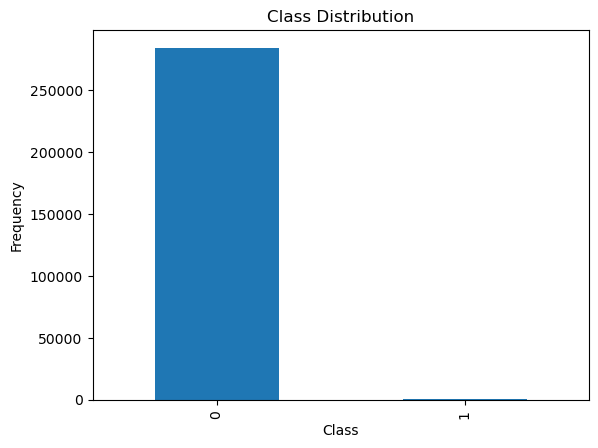

In [4]:
classes = pd.value_counts(data['Class'], sort = True)
classes.plot(kind = 'bar')
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Frequency")

Now, we know our dataset is imbalanced. 1 represents fraudulent transactions and now we can see they're rare.

## Data Splitting
Now, we're splitting the data for the fraudulent and normal transactions.

In [5]:
fraud = data[data['Class'] == 1]
regular = data[data['Class'] == 0]

# We're looking for some attributes of normal transactions to see how fraudulent transactions change

In [6]:
fraud.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [7]:
regular.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

We can see that the average amount for a fraudulent transaction is remarkably higher than that of a regular transaction. Which could suggest that a potential way of identifying fraudulent transactions is the value of said transaction. Next, we want to see if fraudulent transactions occur more during certain time periods.

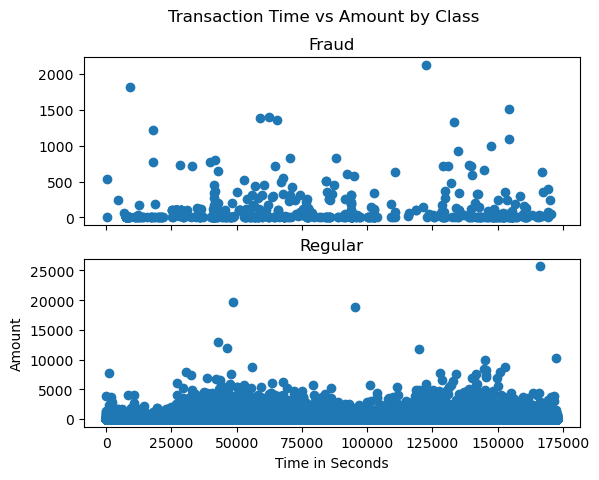

In [8]:
f, (ax1, ax2) = plt.subplots(2,1, sharex=True)
f.suptitle('Transaction Time vs Amount by Class')
ax1.scatter(fraud.Time, fraud.Amount)
ax1.set_title('Fraud')
ax2.scatter(regular.Time, regular.Amount)
ax2.set_title('Regular')
plt.xlabel('Time in Seconds')
plt.ylabel('Amount')
plt.show()

### Data Splitting
Now, we need to split our data so we have training and testing data to use.

In [9]:
# We're using 10 percent of our data
data_sample = data.sample(frac = 0.1, random_state = 1)
Fraud = data_sample[data_sample['Class']==1]
Regular = data_sample[data_sample['Class']==0]
outlier_fraction = len(Fraud)/float(len(Regular))

In [10]:
columns = data_sample.columns.tolist()
# Removing columns we don't need
columns = [c for c in columns if c not in ["Class"]]
target = "Class"

state = np.random.RandomState(42)
X = data_sample[columns]
Y = data_sample[target]
X_outliers = state.uniform(low=0, high=1, size=(X.shape[0], X.shape[1]))


### Model Building
We're comparing the Isolation Forest Algorithm to the Support Vector Machine Algorithm. They are both used for detecting outliers. I would attempt to explain both of them briefly.

- **Isolation Forest Outlier**: this is an ensemble method based on decision trees. Decision trees can be prone to problems such as bias and overfitting. Here, the algorithm constructs a series of decision trees and attempts to isolate outliers at an earlier stage (in terms of depth). These trees are not identical, so the outlier might appear at different depths. However, across all these trees the outliers would be identified earlier than usual.
- **Support Vector Machines**: these are a type of supervised learning algorithm used for classification and, in some cases, regression tasks. The goal of the SVM algorithm is to find the hyperplane (in two-dimensional space, this would be a line) that best separates the classes of data points.

In [11]:
classifiers = {
    "Support Vector Machine": OneClassSVM(kernel='rbf', degree=3, gamma=0.1, nu=0.05, max_iter=-1),
    "Isolation Forest Outliers": IsolationForest(n_estimators=100, max_samples=len(X), contamination=outlier_fraction, random_state=state, verbose=0),
}

In [12]:
print(classifiers.items())

dict_items([('Support Vector Machine', OneClassSVM(gamma=0.1, nu=0.05)), ('Isolation Forest Outliers', IsolationForest(contamination=0.0017234102419808666, max_samples=28481,
                random_state=RandomState(MT19937) at 0x1E301274440))])


In [13]:
n_outliers = len(Fraud)

for i, (clf_name, clf) in enumerate(classifiers.items()):
    clf.fit(X)
    if clf_name == "Support Vector Machine":
        y_prediction = clf.predict(X)
    else:
        scores_prediction = clf.decision_function(X)
        y_prediction = clf.predict(X)

    # Changing the prediction values to be 0 for classic, 1 for fraud
    y_prediction[y_prediction == 1] = 0
    y_prediction[y_prediction == -1] = 1
    n_errors = (y_prediction != Y).sum()
    
    print("{}: {}".format(clf_name, n_errors))
    print("Classification Report: ")
    print(classification_report(Y, y_prediction))

Support Vector Machine: 8516
Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.70      0.82     28432
           1       0.00      0.37      0.00        49

    accuracy                           0.70     28481
   macro avg       0.50      0.53      0.41     28481
weighted avg       1.00      0.70      0.82     28481

Isolation Forest Outliers: 73
Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.26      0.27      0.26        49

    accuracy                           1.00     28481
   macro avg       0.63      0.63      0.63     28481
weighted avg       1.00      1.00      1.00     28481



As we can see, the SVM an Isolation Forest algorithms were evenly matched in terms of precision scores. However, the Isolation Forest Algorithm returned much fewer errors and also had a higher recall score when compared to the Support Vector Machine algorithm.